# Workflow Notebook
This notebook is intended to present models which are loaded from other files as well as the results they allow us to reach.

## Global variables and imports

In [1]:
import csv
import gensim
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from gensim.models import Word2Vec
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence, text
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
NB_CATEGORIES = 52
PADDING = 150

dataFolder = './../posos-data-challenge/challenge_data'
xPath = os.path.join(dataFolder, 'input_train.csv')
yPath = os.path.join(
    dataFolder, 'challenge_output_data_training_file_predict_the_expected_answer.csv')

In [3]:
class CustomModel():
    '''Generic workflow class.'''

    def __init__(self, **kwargs):
        self.verbose = kwargs.get('verbose', False)

        self.nbCategories = kwargs['nbCategories']
        self.paddingLength = PADDING
        self.maxNumberWords = (1e5)
        self.trainable = kwargs.get('trainable', False)

        self.tokenizer = text.Tokenizer(num_words=self.maxNumberWords)

    def preprocess(self, x):
        '''Turns sentences into padded word sequences.'''

        self.tokenizer.fit_on_texts(x)
        sequences = self.tokenizer.texts_to_sequences(x)
        sequences = sequence.pad_sequences(sequences, self.paddingLength)

        return sequences

    def preprocessLabels(self, labels):
        return to_categorical(labels, num_classes=self.nbCategories)

    def train(self, x, y, epochs= 10, batch_size=32, validation_data=None,
              callback=False):
        if callback == True:
            filepath= 'models_checkpoints/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
            checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                                         verbose=1, save_best_only=True, mode='max')
            callbacks_list = [checkpoint]

            self.model.fit(x, y, shuffle='batch', epochs=epochs,
                           batch_size=batch_size, validation_data=validation_data,
                           callbacks=callbacks_list)
        else:
            self.model.fit(x, y, shuffle='batch', epochs=epochs,
                           batch_size=batch_size, validation_data=validation_data)

    def evaluate(self, x, y):
        return self.model.evaluate(x, y)

    def predict(self, x):
        return self.model.predict(x)

## Customize generic workflow

### Perform spelling corrections

In [4]:
correctionsPath = os.path.join(dataFolder, 'corrections.csv')

In [5]:
class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def spellingCorrection(self, x, correct_dict={}, verbose=False):
        corrected_x = []
        for w in x.split():
            if w in correct_dict.keys():
                w_corrected = corrected_dict[w]
                if verbose == True:
                    print('Correction of ' + w + ' in ' + w_corrected)
                w = w_corrected
            corrected_x.append(w)
        return ' '.join(corrected_x)

### Differenciate medics from other words
We here use a list of medication names to distinguish better between common words and specialized ones.

In [6]:
MEDICAMENTS = []
medicsPath = os.path.join(dataFolder, 'medicaments_france.xls')
medic_db = pd.read_excel(medicsPath)

for m in medic_db['Dénomination spécialité']:
    med = []
    for w in m.split():
        if w.lower()!=w:
            med.append(w)
    med = ' '.join(med)
    if len(med)!=0:
        med = med.lower()
        if med not in MEDICAMENTS:
            MEDICAMENTS.append(med.lower())

for m in medic_db['Libellé ATC']:
    med = m.split()[0].lower()
    if med not in MEDICAMENTS:
        MEDICAMENTS.append(med)

print('Liste de médicaments regroupant les libéllés ATC et les'
      'dénominations de spécialité, de taille: {}'.format(len(MEDICAMENTS)))
print('Sample of medicament names: ', MEDICAMENTS[:10])

Liste de médicaments regroupant les libéllés ATC et lesdénominations de spécialité, de taille: 8275
Sample of medicament names:  ['ubistesin adrenalinee', 'forene,', 'sevorane,', 'chirocaïne', 'duodopa', 'synagis', 'kaletra', 'humira', 'norvir', 'viekirax']


In [7]:
class CustomModel(CustomModel):
    '''Extended CustomModel'''
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.medicaments = kwargs['medicaments']

### Designing the Model itself

In [8]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import Input, Conv1D, Dense, Dropout, GlobalMaxPooling1D

class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def buildCNN1D(self, embedding, drop_rate=0.3, nb_filters=128,
                   filter_size=4, padding = PADDING):
        self.embedding = embedding

        my_input = keras.Input(shape=(self.paddingLength,), name= 'input')

        embedding = (Embedding(input_dim=self.embedding.shape[0],
                               output_dim=self.embedding.shape[1],
                               weights=[self.embedding],
                               input_length=self.paddingLength,
                               trainable=self.trainable,
                               name='embedding'))(my_input)
        embedding_dropped = Dropout(drop_rate, name='drop0')(embedding)

        conv1 = Conv1D(nb_filters, filter_size,
                       activation='relu', name='conv1')(embedding_dropped)
        pooled1 = GlobalMaxPooling1D(name='pool1')(conv1)
        dropped1 = Dropout(drop_rate, name='drop1')(pooled1)
        dense1 = Dense(self.nbCategories, activation = 'relu', name = 'dense1')(dropped1)
        
        prob = Dense(self.nbCategories, activation='softmax', name='softmax')(dense1)
        
        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [9]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import LSTM, Embedding, Dropout


class CustomModel(CustomModel):
    '''Extended CustomModel'''
    
    def buildLSTM(self, embedding, drop_rate=0.3, nb_filters=128, filter_size=3):
        self.embedding = embedding

        my_input = Input(shape=(self.paddingLength,), name= 'input')

        embedding = Embedding(input_length=self.paddingLength,
                                input_dim=self.embedding.shape[0],
                                output_dim=self.embedding.shape[1],
                                weights=[self.embedding],
                                trainable=self.trainable,
                                name='embedding')(my_input)

        embedding_dropped = Dropout(drop_rate, name='drop0')(embedding)
#         CNN cell
#         conv1 = Conv1D(nb_filters, filter_size, activation='relu', name='conv1',
#                        padding = 'same')(embedding_dropped)
#         pooled_conv1 = MaxPooling1D(pool_size = 2, name = 'pool1')(conv1)
#         dropped1 = Dropout(drop_rate, name = 'drop1')(pooled_conv1)
        lstm1 = LSTM(100, name = 'lstm1', dropout= drop_rate,
                     recurrent_dropout= drop_rate)(embedding_dropped)
        dense1 = Dense(self.nbCategories, activation = 'relu', name = 'dense1')(lstm1)
        prob = Dense(self.nbCategories, activation='softmax', name='softmax')(dense1)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

# implement a 2D convnet for text classification: 
#inspired from : https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [10]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import MaxPooling1D, LSTM, Conv1D


class CustomModel(CustomModel):
    '''Extended CustomModel'''
    
    def buildLSTM_CNN(self, embedding, drop_rate=0.3, nb_filters=128, filter_size=3):
        self.embedding = embedding

        my_input = Input(shape=(self.paddingLength,), name= 'input')

        embedding = Embedding(input_length=self.paddingLength,
                                input_dim=self.embedding.shape[0],
                                output_dim=self.embedding.shape[1],
                                weights=[self.embedding],
                                trainable=self.trainable,
                                name='embedding')(my_input)

        embedding_dropped = Dropout(drop_rate, name='drop0')(embedding)
        conv1 = Conv1D(nb_filters, filter_size, activation='relu',
                       name='conv1', padding='same')(embedding_dropped)
        pooled1 = MaxPooling1D(pool_size = 2, name = 'pool1')(conv1)
        dropped1 = Dropout(drop_rate, name = 'drop1')(pooled1)
        lstm1 = LSTM(100, name = 'lstm1',
                     dropout= drop_rate, recurrent_dropout= drop_rate)(dropped1)
        prob = Dense(self.nbCategories,
                     activation='softmax', name='dense1')(lstm1)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

# implement a 2D convnet for text classification: 
#inspiration is here : http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

In [11]:
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras import Input
from keras.layers import (Input, Conv2D, Dense, Dropout,
                          MaxPooling2D, Flatten, Concatenate, Reshape)


class CustomModel(CustomModel):
    '''Extended CustomModel'''

    def buildCNN2D(self, embedding, drop_rate=0.3, nb_filters=128, filter_size=[3, 5, 8],
                   padding=PADDING):
        if np.isscalar(filter_size):
            filter_size = [3, 5, 8]
            print("WARNING: You have to enter a list for the different\
            filter sizes, we modified directly to: {}".format(filter_size))
        
        self.embedding = embedding

        my_input = Input(shape=(self.paddingLength, ), name= 'input')

        embedding = Embedding(input_dim=self.embedding.shape[0],
                               output_dim=self.embedding.shape[1],
                               weights=[self.embedding],
                               input_length=self.paddingLength,
                               trainable=self.trainable,
                               name='embedding')(my_input)
        embedding = Reshape((padding, self.embedding.shape[1], 1))(embedding)
        embedding_dropped = Dropout(drop_rate, name='drop0')(embedding)
        
        # we concatenate 3 filter sizes
        conv0 = Conv2D(nb_filters, (filter_size[0], self.embedding.shape[1]),
                       activation='relu', name='conv0', padding='valid')(embedding_dropped)
        pooled0 = MaxPooling2D(pool_size=(padding - filter_size[0] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool0')(conv0)
        
        conv1 = Conv2D(nb_filters, (filter_size[1], self.embedding.shape[1]),
                       activation='relu', name='conv1', padding='valid')(embedding_dropped)
        pooled1 = MaxPooling2D(pool_size = (padding - filter_size[1] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool1')(conv1)
        
        conv2 = Conv2D(nb_filters, (filter_size[2], self.embedding.shape[1]),
                       activation='relu', name='conv2', padding='valid')(embedding_dropped)
        pooled2 = MaxPooling2D(pool_size = (padding - filter_size[2] + 1, 1),
                               strides=(1, 1), padding='valid', name='pool2')(conv2)
        
        concatenated = Concatenate(axis = 1)([pooled0, pooled1, pooled2])
        flattened = keras.layers.Flatten()(concatenated)
        dropped1 = Dropout(drop_rate, name='drop1')(flattened)  
        prob = Dense(self.nbCategories, activation='softmax', name='dense2')(dropped1)

        self.model = Model(my_input, prob)

        self.model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

SyntaxError: invalid syntax (<ipython-input-11-b5765693e142>, line 7)

## Training the Model

In [47]:
# Model variables
TRAINABLE = False # never train the embedding for the classification task (overfitting)
PRE_TRAINED_DIM = 300 # Size of the pretrained embedding used here

In [48]:
# Model instance creation
model = CustomModel(nbCategories=NB_CATEGORIES, trainable=TRAINABLE, medicaments=MEDICAMENTS)

# Loading, parsing and spliting training and testing data
x = pd.read_csv(xPath, delimiter=';', usecols=[1]).values.ravel()
y = pd.read_csv(yPath, delimiter=';', usecols=[1]).values.ravel()

In [49]:
# Correct spelling mistakes
corrected_dict = {}
for key, val in csv.reader(open(correctionsPath)):
    corrected_dict[key] = val
for i, s in enumerate(x):
    x[i] = model.spellingCorrection(s, corrected_dict, verbose=False)

In [50]:
# Print some info about our vocabulary
model.preprocess(x)
x_vocab  = list(model.tokenizer.word_index.keys())
print('Vocabulary size: ', len(x_vocab))

Vocabulary size:  10141


In [19]:
# Loading and using pretrained embedding

# Using fasttext
#path2embedding = '../word_embeddings/wiki.fr.vec'
# using fasttext trained on wiki_fr and emea database
path2embedding = '../word_embeddings/retrained_fr.vec'
pre_trained_wv = gensim.models.KeyedVectors.load_word2vec_format(path2embedding,
                                                                 binary=False)

# We use an embedding size of len(x_vocab) + 1 because the 0 is used for the padding
embeddings = np.zeros((len(x_vocab) + 1 , PRE_TRAINED_DIM))
not_in_pretrained = []

for word, idx in model.tokenizer.word_index.items():
    if word not in pre_trained_wv.vocab:
        vec = np.zeros(PRE_TRAINED_DIM)
        not_in_pretrained.append(word)
    else:
        vec = pre_trained_wv[word]

    # word_to_index is 1-based! the 0-th row, used for padding, stays at zero
    embeddings[idx,] = vec

print('---------- Embedding Created ----------')
print('Number of words in corpus that do not appear in '
      'pretrained Fasttext: ', len(not_in_pretrained))

---------- Embedding Created ----------
Number of words in corpus that do not appear in pretrained Fasttext:  2243


In [51]:
# saving the embedding for convenience
#np.save('challenge_data/fasttext_voc_not_corrected.npy', embeddings)
#np.save('challenge_data/fasttext_emb.npy', embeddings)
np.save('challenge_data/fasttext_retrained.npy', embeddings)
#embeddings = np.load('challenge_data/fasttext_emb.npy')
#embeddings = np.load('challenge_data/fasttext_voc_not_corrected.npy')
embeddings = np.load('challenge_data/fasttext_retrained.npy')

In [53]:
# Model parameters among (drop_rate=0.3, nb_filters=32, filter_size=3)
DROP_RATE = 0.3
NB_FILTERS = 256
FILTER_SIZE = 3
#FILTERS_SIZES = []
# Build our model
model.buildLSTM_CNN(embeddings, drop_rate=DROP_RATE, nb_filters=NB_FILTERS,
                    filter_size=FILTER_SIZE)
model.model.summary()

print('Total number of model parameters:', model.model.count_params())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 150)               0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 300)          3042600   
_________________________________________________________________
drop0 (Dropout)              (None, 150, 300)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 150, 256)          230656    
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 75, 256)           0         
_________________________________________________________________
drop1 (Dropout)              (None, 75, 256)           0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 100)               142800    
__________

In [54]:
# Preprocess input data and labels before training
y = model.preprocessLabels(y)
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

xTrain = model.preprocess(xTrain)
xTest = model.preprocess(xTest)

In [55]:
# Training
BATCH_SIZE = 32
EPOCHS = 10

model.train(xTrain, yTrain, epochs=EPOCHS, batch_size= BATCH_SIZE,
            validation_data=(xTest, yTest))

Train on 6422 samples, validate on 1606 samples
Epoch 1/10
6422/6422 [==============================] - 41s 6ms/step - loss: 3.1928 - acc: 0.2301 - val_loss: 2.9828 - val_acc: 0.2771
Epoch 2/10
6422/6422 [==============================] - 24s 4ms/step - loss: 2.9359 - acc: 0.2778 - val_loss: 2.8483 - val_acc: 0.3107
Epoch 3/10
6422/6422 [==============================] - 26s 4ms/step - loss: 2.7437 - acc: 0.3197 - val_loss: 2.7539 - val_acc: 0.3163
Epoch 4/10
6422/6422 [==============================] - 28s 4ms/step - loss: 2.5780 - acc: 0.3539 - val_loss: 2.6977 - val_acc: 0.3294
Epoch 5/10
6422/6422 [==============================] - 28s 4ms/step - loss: 2.4261 - acc: 0.3832 - val_loss: 2.6657 - val_acc: 0.3344
Epoch 6/10
6422/6422 [==============================] - 30s 5ms/step - loss: 2.2642 - acc: 0.4223 - val_loss: 2.6866 - val_acc: 0.3319
Epoch 7/10
6422/6422 [==============================] - 30s 5ms/step - loss: 2.1172 - acc: 0.4604 - val_loss: 2.7865 - val_acc: 0.2970
Epoch 8

## Model Evaluation

In [105]:
loss = model.evaluate(xTest, yTest)

prediction = model.predict(xTest)
predictionCategories = np.argmax(prediction, axis=1)
yTestCategories = np.argmax(yTest, axis=1)
accuracy = 100 * sum([predictionCategories[i] == yTestCategories[i]
                      for i in range(len(yTestCategories))]) / len(yTestCategories)

print('Accuracy: {:.2f} %\nLoss: {}'.format(accuracy, str(loss)))

1606/1606 [==============================] - 2s 1ms/step
Accuracy: 33.06 %
Loss: [2.6934158825785257, 0.33063511830635117]


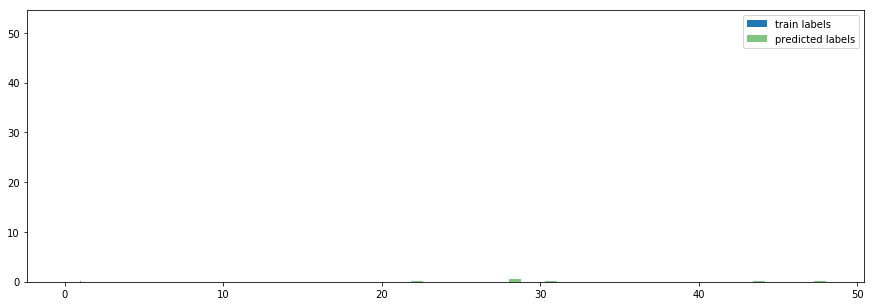

In [110]:
plt.figure(figsize=(15, 5))

plt.hist(y, bins=NB_CATEGORIES, label='train labels', density=True, alpha=1)
plt.hist(predictionCategories, bins=NB_CATEGORIES,
         label='predicted labels', density=True, alpha=0.6)
plt.axis
plt.legend()
plt.show()

In [20]:
yTestCategories

array([37, 44, 44, ..., 48, 45, 44])